# Serie de precios

In [10]:
# Lectura y limpieza del conjunto de datos
import pandas as pd
import matplotlib.pyplot as plt
precios = pd.read_excel("./Data/Precios_combustibles.xlsx", skiprows = 7, nrows = 195)
precios = precios.drop(precios.index[0]).reset_index(drop=True)
precios['FECHA'] = pd.to_datetime(precios['FECHA'])

precios.head()

,FECHA,Tipo de Cambio,Superior,Regular,Diesel,Bunker,Glp Cilindro 25Lbs.,Unnamed: 7
0,2025-01-01,7.70625,28.95,27.45,25.47,18.74,110,4.4
1,2025-01-02,7.7074,28.95,27.45,25.47,18.74,110,4.4
2,2025-01-03,7.70971,28.95,27.45,25.47,18.74,110,4.4
3,2025-01-04,7.70971,28.95,27.45,25.47,18.74,110,4.4
4,2025-01-05,7.70971,28.95,27.45,25.47,18.74,110,4.4


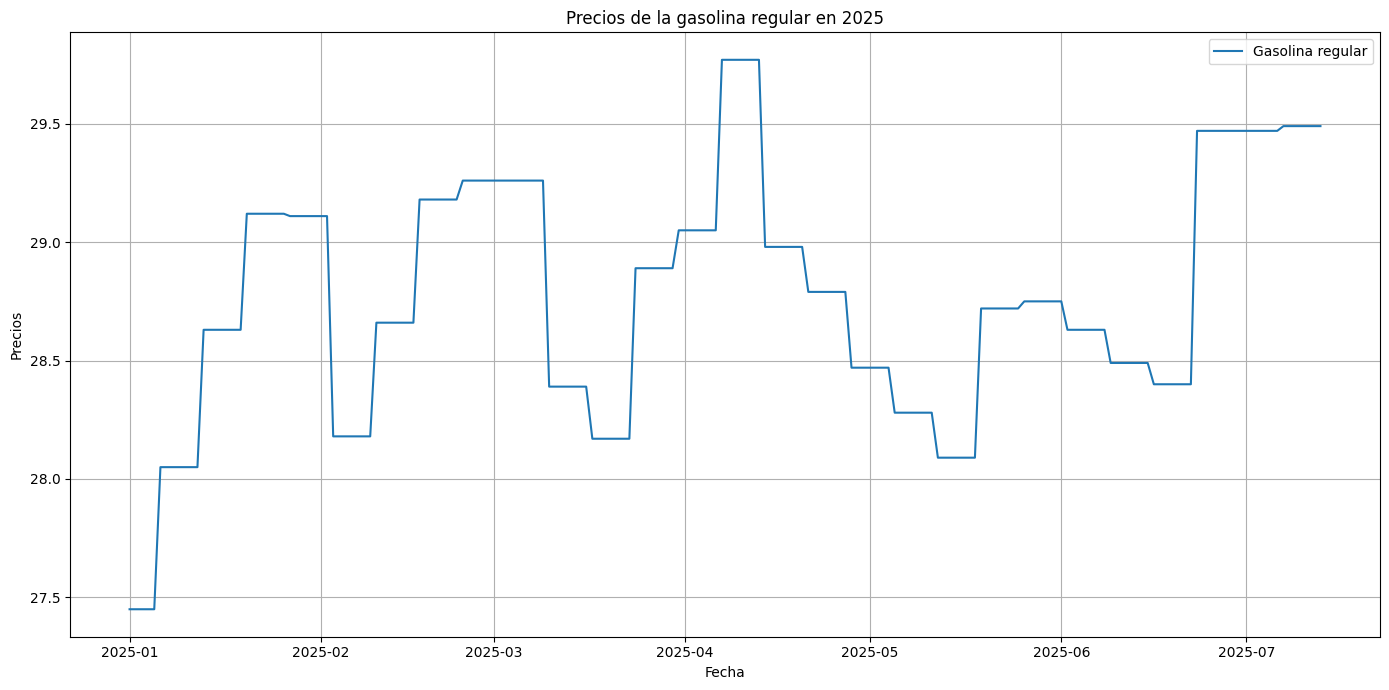

In [11]:
precios_regular = precios[['FECHA', 'Regular']]
precios_regular

plt.figure(figsize=(14, 7))
plt.plot(precios_regular['FECHA'], precios_regular['Regular'], label='Gasolina regular')

plt.title('Precios de la gasolina regular en 2025')
plt.xlabel('Fecha')
plt.ylabel('Precios')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Ahora analizamos sus componentes

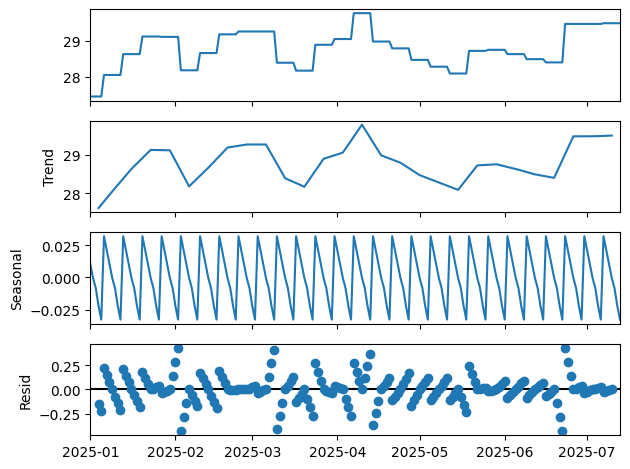

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
precios_regular.set_index('FECHA', inplace=True)

descomposicion = seasonal_decompose(precios_regular)
descomposicion.plot();

Se observa que la varianza no es constante y también vemos una ligera tendencia, vamos a aplicar el test de Fuller para confirmar si hay tendencia. 

In [13]:
from statsmodels.tsa.stattools import adfuller

print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(precios_regular, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -3.051074
p-value                        0.030392
# de retardos usados           0.000000
# de observaciones usadas    193.000000
Critical Value (1%)           -3.464694
Critical Value (5%)           -2.876635
Critical Value (10%)          -2.574816
dtype: float64


El p-value revela que la serie no tiene tendencia, pues el p-value es menor que 0.05. Por lo tanto la serie es estacionaria y no debemos aplicar ningun diferenciación o transformación. Ahora vamos a estandarizar la serie. 

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
precios_escalados = scaler.fit_transform(precios_regular.values.reshape(-1, 1))  # reshape necesario
print(precios_escalados[1:7])

[[-2.59105265]
 [-2.59105265]
 [-2.59105265]
 [-2.59105265]
 [-1.41385309]
 [-1.41385309]]


Ahora vamos a dividir en conjuntos de entrenamiento y prueba. Usarémos el 60% de la ifnromación como datos de entrenamineto, el 20% como datos de validación y el 20% restante como datos de prueba. 

In [16]:

import numpy as np
n = len(precios_escalados)
entrenamiento = round(0.6 * n)
val_prueba = round(0.2 * n)


train = precios_escalados[0:entrenamiento]
validation = precios_escalados[entrenamiento:entrenamiento + val_prueba + 1]
test = precios_escalados[(entrenamiento + val_prueba) - 1:]


train = np.insert(train, 0, 0)


train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificamos tamaños
print(f"Entrenamiento: {len(train)}")
print(f"Validación: {len(validation)}")
print(f"Prueba: {len(test)}")


Entrenamiento: 117
Validación: 40
Prueba: 40


Sabemos que para que el modelo LSTM funcione, debemos usar una serie supervisada, vamos a aplicar ese transformación. Tendremos en cuenta que el dato anterior sirve para predecir el siguiente. 

In [17]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

# Creación del modelo

Ahora vamos a crear el modelo. El primero modelo tendrá los siguientes componentes:

- 2 capas LSTM las cuáles nos ayudaran a comprender de mejor forma los patrones a lo largo del tiempo. 
- 1 capa de olvido con 0.5 la cupal nos ayudará a prevenir overfitting
- 2 capas densas, la primera nos va a ayudar a entender los patrones recolectados en las capas LSTM, la última nos dará el output final.

In [49]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

batch_size = 32 #Vamos a usar 32 de batchsize
timesteps = 1 #Porque solo tendremos como entrada un día  
n_features = 1  # Porque la variable de salida solo es el precio del siguiente día. 
n_units = 64 #Usaremos 64 unidades de procesamiento en este modelo inicial 

model = Sequential()


model.add(LSTM(units=n_units,
               stateful=False,
               input_shape=(timesteps, n_features),
               return_sequences=False)) 

'''
model.add(LSTM(units=n_units,
               stateful=False,
               input_shape=(timesteps, n_features),
               return_sequences=False)) #Segunda capa LSTM
'''

#model.add(Dense(128, activation="sigmoid")) # Nos ayuda a comprender mejor los patrones encontrados anteriormente, tendrá una relu como activación


model.add(Dense(1)) #Capa de salida.


model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

c:\Users\ppguz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Ahora entrenamos el modelo. Vamos a usar 150 épocas

In [50]:
epocas = 150
history= model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.1797 - val_loss: 0.5205
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1470 - val_loss: 0.5074
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1180 - val_loss: 0.4954
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0896 - val_loss: 0.4838
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0616 - val_loss: 0.4723
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0340 - val_loss: 0.4610
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0065 - val_loss: 0.4496
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9793 - val_loss: 0.4383
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9521 - val_loss: 0.4269
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9251 - val_loss: 0.4154
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8981 - val_loss: 0.4038
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8711 - val_lo

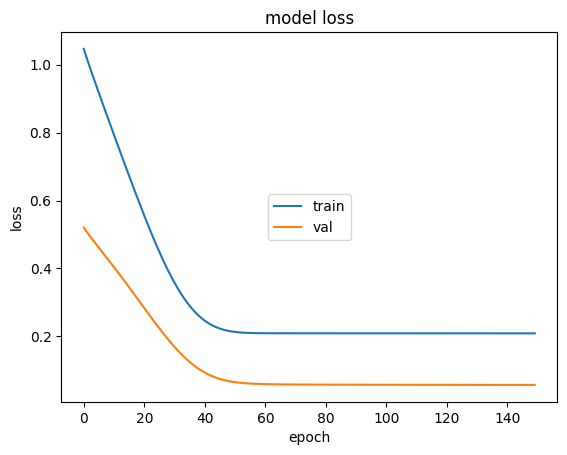

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

Ahora predecimos

In [52]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,model, 1,scaler,dif=True,dif_cant=1, Series = precios_regular.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,model, 1,scaler,dif=True,dif_cant=1, Series = precios_regular.values , n=entrenamiento+val_prueba)

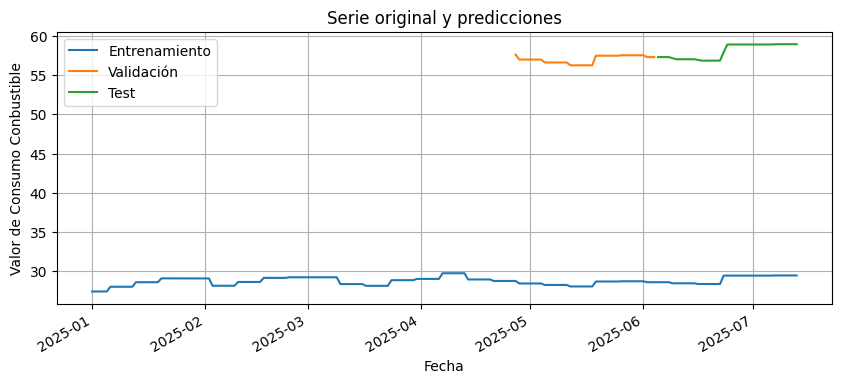

In [53]:
df_val = pd.DataFrame(prediccion_val,index=precios_regular[(entrenamiento):entrenamiento+val_prueba].index)
start_test = entrenamiento + len(df_val)
end_test = start_test + len(prediccion_test)

df_test = pd.DataFrame(prediccion_test, index=precios_regular[start_test:end_test].index)




plt.figure(figsize=(10,4))
plt.plot(precios_regular,        label='Entrenamiento')
plt.plot(df_val,    label='Validación')

plt.plot(df_test,   label='Test')

plt.title('Serie original y predicciones')
plt.xlabel('Fecha')
plt.ylabel('Valor de Consumo Conbustible')
plt.grid(True)
plt.legend(loc='upper left')

plt.gcf().autofmt_xdate()
plt.show()

In [55]:
df_test

,0
FECHA,
2025-06-05,57.273118
2025-06-06,57.273118
2025-06-07,57.273118
2025-06-08,57.273118
2025-06-09,57.133118
2025-06-10,56.998587
2025-06-11,56.998587
2025-06-12,56.998587
2025-06-13,56.998587
